# Networks: structure, evolution & processes
**Internet Analytics - Lab 2**

---

**Group:** *F*

**Names:**

* *Hippolyte Lefebvre*
* *Micheli Vincent*
* *Dessimoz Franck*

---

#### Instructions

*This is a template for part 4 of the lab. Clearly write your answers, comments and interpretations in Markodown cells. Don't forget that you can add $\LaTeX$ equations in these cells. Feel free to add or remove any cell.*

*Please properly comment your code. Code readability will be considered for grading. To avoid long cells of codes in the notebook, you can also embed long python functions and classes in a separate module. Don’t forget to hand in your module if that is the case. In multiple exercises, you are required to come up with your own method to solve various problems. Be creative and clearly motivate and explain your methods. Creativity and clarity will be considered for grading.*

---

## 2.4 PageRank

### 2.4.1 Random Surfer Model

#### Exercise 2.12

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import collections

abs_graph = nx.read_adjlist("../data/absorbing.graph", create_using = nx.DiGraph())
comp_graph = nx.read_adjlist("../data/components.graph", create_using = nx.DiGraph())

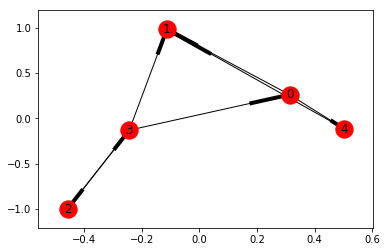

In [2]:
nx.draw_networkx(abs_graph)
plt.show()

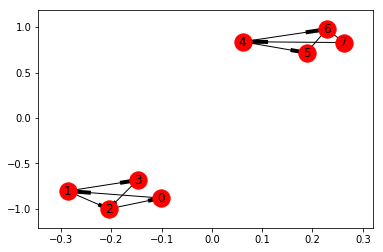

In [3]:
nx.draw_networkx(comp_graph)
plt.show()

In [4]:
def random_surfer(graph,n):
    current = np.random.choice(graph.nodes())
    visit = collections.defaultdict(int)
    
    for i in range(n):
        visit[current] += 1
        neighbors = list(graph.neighbors(current))
        if len(neighbors) > 0:
            current = np.random.choice(neighbors)
   
    return dict([(k,v/n) for k,v in visit.items()])
        
print(random_surfer(abs_graph,1000))
print(random_surfer(comp_graph,1000))

{'2': 0.001, '3': 0.001, '0': 0.001, '1': 0.997}
{'5': 0.151, '6': 0.283, '7': 0.283, '4': 0.283}


In the first graph, we end up stuck in an absorbing state (i.e node 1).
In the second graph, we also end up stuck in an absorbing class (i.e either 4,5,6,7 or 0,1,2,3).

#### Exercise 2.13

In [5]:
def smart_random_surfer(graph,n,damping):
    current = np.random.choice(graph.nodes())
    visit = collections.defaultdict(int)
    
    for i in range(n):
        visit[current] += 1
        neighbors = list(graph.neighbors(current))
        if np.random.randint(0,101) > damping:
            if len(neighbors) > 0:
                current = np.random.choice(neighbors)
            else:
                current = np.random.choice(graph.nodes())
        else:
            current = np.random.choice(graph.nodes())
   
    return dict([(k,v/n) for k,v in visit.items()])
        
print(smart_random_surfer(abs_graph,1000,15))
print(smart_random_surfer(comp_graph,1000,15))

{'4': 0.151, '1': 0.351, '2': 0.139, '3': 0.197, '0': 0.162}
{'4': 0.12, '5': 0.067, '6': 0.129, '7': 0.135, '0': 0.155, '1': 0.154, '3': 0.086, '2': 0.154}


Yes it does since in the first graph 1 is still the highest ranked node but we also get a fair ranking of the other nodes. In the second graph nodes ranking are also fair and do not take into account the starting class.

---

### 2.4.2 Power Iteration Method

#### Exercise 2.14: Power Iteration method

In [6]:
wiki_graph = nx.read_adjlist("../data/wikipedia.graph", create_using = nx.DiGraph())

In [7]:
#The implementation is straightforward and uses the course slides recommendations for the parameters steps and theta
def power_iteration(graph,steps,theta):
    n = graph.number_of_nodes()
    nodes = graph.nodes()
    h = np.zeros((n,n))
    w = np.zeros(n)
    
    for u in nodes:
        for v in nodes:
            if graph.has_edge(u,v):
                h[int(u),int(v)] = 1/len(list(graph.neighbors(u)))
    
    for i in range(n):
        if np.array_equal(h[i],np.zeros(n)):
            w[i] = 1
    
    dangling = (1/n) * np.outer(w,np.ones(n))
    h_hat = h + dangling
    restart = (1/n)*np.ones((n,n))
    
    g = h_hat*theta + (1-theta)*restart
    
    pi_zero = (1/n) * np.ones(n)
    
    for i in range(steps):
        pi_zero = np.dot(pi_zero,g)
   
    return pi_zero

ranks = power_iteration(wiki_graph,100,0.85)

In [8]:
from pandas import DataFrame
df = DataFrame.from_csv("../data/wikipedia_titles.tsv", sep="\t")

#Ordered_numbers holds original indexes of the sorted ranks
ordered_numbers = np.argsort(ranks)[::-1]
result = [df.iloc[r]['page_title'] for r in ordered_numbers[:10]]
print("Top 10 pages according to their PageRank score:")
for i,r in enumerate(result,1):
    print(i,r)

Top 10 pages according to their PageRank score:
1 United States
2 United Kingdom
3 France
4 Europe
5 Germany
6 England
7 World War II
8 Latin
9 India
10 English language


---

### 2.4.3 Gaming the system *(Bonus)*

#### Exercise 2.15 *(Bonus)*

In [12]:
print(df.loc[df['page_title'] == 'History of mathematics'])

                      page_title
#page_id                        
2463      History of mathematics


In [13]:
print('History of mathematics')
print("Score: ",ranks[2463])
print("Rank: ", ordered_numbers.tolist().index(2463)+1)

History of mathematics
Score:  9.84634105555e-05
Rank:  2530


Our strategy to increase the PageRank score of the page History of mathematics is the following:  
We will sort pages according to their page rank score divided by their out degree. Then we will add an edge from the top 300 sorted pages to the History of Mathematics page. We are just using the basic PageRank score formula. Basically, we increase the probability that the random walk will go through our page by making highly probable pages with few links point to it.

In [20]:
G = wiki_graph.copy()

#Get the inverted out degree or 0 if absorbing node
inv_out_degs = [1/len(list(G.neighbors(node))) if len(list(G.neighbors(node))) > 0 else 0 for node in G.nodes()]
#Get the top 300 "new" sorted nodes
smart_ranks = np.argsort(ranks * inv_out_degs)[::-1][:300]

for i in smart_ranks:
    G.add_edge(i,2463)

#Previous part bis repetita
pi_victory = power_iteration(G,100,0.85)
order2 = np.argsort(pi_victory)[::-1]
result2 = [df.iloc[r]['page_title'] for r in order2[:10]]
print("Top 10 pages according to their PageRank score:")
for i,r in enumerate(result2,1):
    print(i,r)

Top 10 pages according to their PageRank score:
1 History of mathematics
2 Mathematics
3 United States
4 France
5 Latin
6 United Kingdom
7 England
8 Europe
9 Italy
10 China


We manage to obtain the number one spot. We even give the number two spot to Mathematics !